In [50]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_astradb import AstraDBVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import RetrievalQA
from dotenv import load_dotenv
from typing import Literal, List
from typing_extensions import TypedDict
import os
from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
import requests
from datetime import datetime
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from typing import TypedDict


In [ ]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
ASTRA_API_KEY = os.getenv("ASTRA_API_KEY")
ASTRA_ENDPOINT = os.getenv("ASTRA_ENDPOINT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

In [3]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY, temperature=0.1)
llm.invoke("Hi").content

'Hi there! How can I help you today?\n'

In [4]:
gemini_embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vector_store = AstraDBVectorStore(
        embedding=gemini_embedding,
        api_endpoint=ASTRA_ENDPOINT,
        namespace="default_keyspace",
        token=ASTRA_API_KEY,
        collection_name="travel",
    )

retriever = vector_store.as_retriever()

In [ ]:
class GraphState(TypedDict, total=False):
    destination: str
    rag_query: str
    rag_result: str
    user_message: str
    itinerary_plan: str
    travel_days : int
    final_answer : str
    journey_date: str
    weather_info: str

In [6]:
def rag_node(state: GraphState) -> GraphState:
    query = state["destination"]
    query =f"What are the top attractions in {query}?"

    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
    answer = qa_chain.run(query)

    state["rag_result"] = answer
    return state

In [7]:
def web_search_node(state: GraphState) -> GraphState:
    destination = state["destination"]
    travel_days = state.get("travel_days", 1)

    search_query = f"Best {travel_days}-day travel itinerary for {destination}"
    search_tool = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=3)
    results = search_tool.run(search_query)

    combined_content = "\n\n".join([res["content"] for res in results])

    prompt = f"""
    Create a detailed {travel_days}-day travel itinerary for {destination}
    based on the following web content. Suggest attractions per day, meal stops,
    and travel advice.

    Content:
    {combined_content}

    Answer:"""

    response = llm.invoke(prompt)
    state["web_result"] = response
    return state

In [8]:
def combine_results_node(state: GraphState) -> GraphState:
    destination = state["destination"]
    travel_days = state.get("travel_days", 1)

    rag_result = state.get("rag_result", "")
    web_result = state.get("web_result", "")

    prompt = f"""
    You are a smart travel planner assistant.

    The user wants to travel to **{destination}** for **{travel_days} day(s)**.

    You have two sources of information:
    1. **Tour guidebook (PDF) answer**: {rag_result}
    2. **Latest web search itinerary**: {web_result}

    Your task is to **combine both sources** to generate the most useful, day-wise, and practical travel itinerary. Keep it short and focused per day with top attractions, local tips, and smart time planning. Mention meals or breaks where helpful.

    Format your answer like:

    Day 1:
    - Attraction 1
    - Attraction 2
    - ...
    Day 2:
    - ...

    Make sure to adjust based on the number of travel days: {travel_days}.
    If you don't have enough information for a day, just say "No information available for this day."""

    final_response = llm.invoke(prompt)
    state["final_answer"] = final_response
    return state


In [10]:
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

In [20]:
def weather_node(state: GraphState) -> GraphState:
    location = state["destination"]
    journey_date = state["journey_date"]

    url = f"https://api.weatherapi.com/v1/forecast.json?key={WEATHER_API_KEY}&q={location}&days=7&aqi=no&alerts=no"
    response = requests.get(url)
    data = response.json()

    forecast_days = data.get("forecast", {}).get("forecastday", [])
    forecast = "No weather info available for the selected date."

    for day in forecast_days:
        if day["date"] == journey_date:
            condition = day["day"]["condition"]["text"]
            avg_temp = day["day"]["avgtemp_c"]
            max_temp = day["day"]["maxtemp_c"]
            min_temp = day["day"]["mintemp_c"]
            forecast = (
                f"Weather on {journey_date} in {location}:\n"
                f"Condition: {condition}\n"
                f"Average Temp: {avg_temp}°C\n"
                f"High: {max_temp}°C, Low: {min_temp}°C"
            )
            break

    state["weather_info"] = forecast
    return state


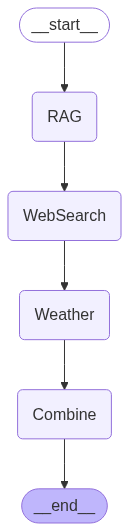

In [ ]:
app = StateGraph(GraphState)

app.add_node("RAG", rag_node)
app.add_node("WebSearch", web_search_node)
app.add_node("Weather", weather_node)
app.add_node("Combine", combine_results_node)

app.set_entry_point("RAG")

app.add_edge("RAG", "WebSearch")
app.add_edge("WebSearch", "Weather")
app.add_edge("Weather", "Combine")
app.add_edge("Combine", END)

app.compile()